In [1]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip

import math
import torch
# import shash
from shash.shash_torch import Shash
#import matplotlib.colors as mcolorsxx|

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
from databuilder.data_generator import multi_input_data_organizer
from databuilder.data_generator import ClimateData
import databuilder.data_generator as data_generator
from utils.filemethods import open_data_file as open_data_file
from databuilder.data_loader import universaldataloader
import analysis.analysis_metrics as analysis_metrics
from utils.utils import get_config

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
numpy version = 1.26.4
xarray version = 2024.5.0
pytorch version = 2.0.0.post104


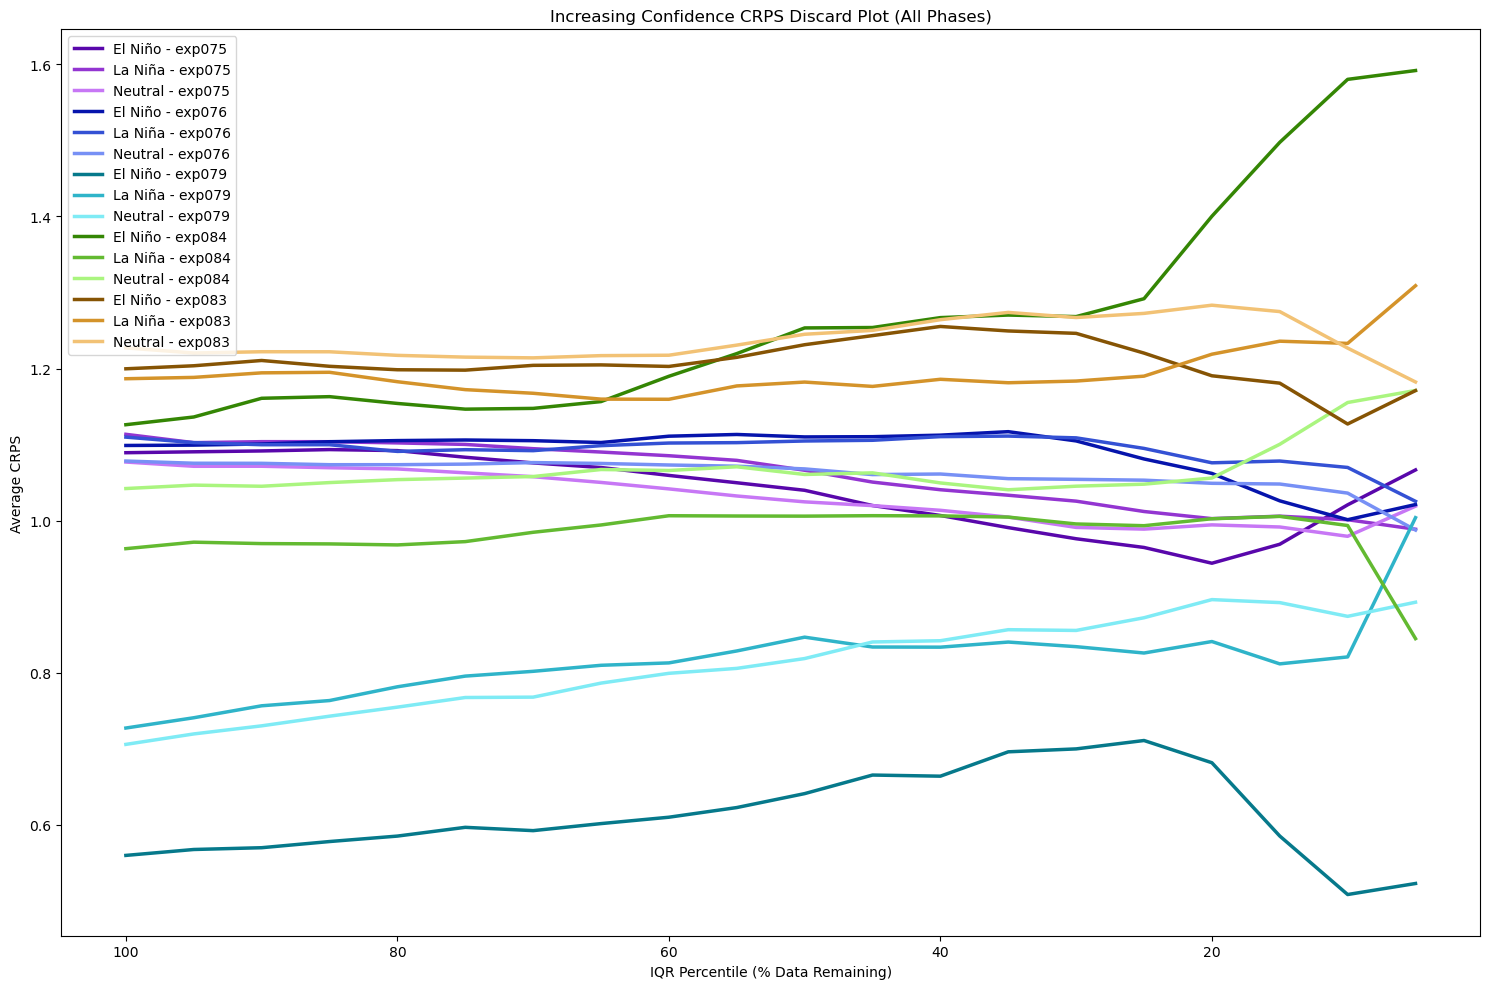

In [20]:
# Open discard plot data from appropriate experiments: 
E3SM_cnn_E3SM_exp = "exp075"
E3SM_snn_E3SM_exp = "exp076"
OBS_cnn_OBS_exp = "exp079"
OBS_snn_OBS_exp = "exp084"
OBS_cnn_E3SM_exp = "exp083"

plt.figure(figsize=(15, 10))
plt.gca().invert_xaxis()  # high confidence = low IQR = right side of plot

exps = [E3SM_cnn_E3SM_exp, E3SM_snn_E3SM_exp, OBS_cnn_OBS_exp, OBS_snn_OBS_exp, OBS_cnn_E3SM_exp]
color_themes = {
    0: ["#5907AB", "#9335D1", "#C777F5"], 
    1:[ "#0614AC", "#3451D4", "#7790F5"],
    2: ["#06798B", "#2FB4C9", "#7FEBF5"],
    3: ['#348604', '#63BA31', '#AAF57F'],
    4: ['#865404', '#D4932A', '#F2C275'],
    5: ['#890730', '#D03F6D', '#F484A7']
}
for iexp, experiment_name in enumerate(exps):
    filename = str("/pscratch/sd/p/plutzner/E3SM/saved/output/" + str(experiment_name) + "/" + str(experiment_name) + "_combined_ENSO_IQR_discard_data.pkl")
    try:
        with open(filename, 'rb') as f:
            discard_data = pickle.load(f)
    except (pickle.UnpicklingError, EOFError, UnicodeDecodeError):
        try:
            # If it fails, try gzip
            with gzip.open(filename, 'rb') as f:
                discard_data = pickle.load(f)
        except Exception as e:
            raise RuntimeError(f"Failed to load file with both normal and gzip methods: {e}")

    percentile_dict = discard_data['percentiles']
    crps_dict = discard_data['crps']

    plt.plot(percentile_dict['EN'], crps_dict['EN'], label=f'El Niño - {experiment_name}', linewidth = 2.5, color = color_themes[iexp][0])
    plt.plot(percentile_dict['LN'], crps_dict['LN'], label=f'La Niña - {experiment_name}', linewidth = 2.5, color = color_themes[iexp][1])
    plt.plot(percentile_dict['NE'], crps_dict['NE'], label=f'Neutral - {experiment_name}', linewidth = 2.5, color = color_themes[iexp][2])

    plt.xlabel('IQR Percentile (% Data Remaining)')
    plt.ylabel('Average CRPS')
    plt.title('Increasing Confidence CRPS Discard Plot (All Phases)')
    plt.legend()
    plt.tight_layout()

In [ ]:
 plt.figure(figsize=(8, 6))
plt.gca().invert_xaxis()  # high confidence = low IQR = right side of plot

plt.plot(percentile_dict['EN'], crps_dict['EN'], label='El Niño', linewidth = 1.5, color='#c77f08')
plt.plot(percentile_dict['LN'], crps_dict['LN'], label='La Niña', linewidth = 1.5, color='#5b9da4')
plt.plot(percentile_dict['NE'], crps_dict['NE'], label='Neutral', linewidth = 1.5, color='#c2ab85')

plt.axhline(y=crps_climatology.mean(), color='grey', linestyle='--', label='CRPS Climatology Mean')
plt.xlabel('IQR Percentile (% Data Remaining)')
plt.ylabel('Average CRPS')
plt.title('Increasing Confidence CRPS Discard Plot (All Phases)')
plt.legend()
plt.tight_layout()
plt.savefig(str(config["perlmutter_figure_dir"]) + str(config["expname"]) + '/' + str(keyword) + '_CRPS_IQR_DiscardPlot_ENSOcombined.png', format='png', bbox_inches ='tight', dpi = 250)

plot_data_dict = {
    'percentiles': percentile_dict,
    'crps': crps_dict
}